In [43]:
#import necessary library 
import pandas as pd 
from sklearn.model_selection import train_test_split ,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report ,confusion_matrix
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout


from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import time 



In [3]:
df=pd.read_csv("../data/processed/data_v1.csv")


colums to drop are "Caudal_impulses" "Oil_level" ,"Pressure_switch" ,"LPS"

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1200000 non-null  int64  
 1   TP2              1200000 non-null  float64
 2   TP3              1200000 non-null  float64
 3   H1               1200000 non-null  float64
 4   DV_pressure      1200000 non-null  float64
 5   Reservoirs       1200000 non-null  float64
 6   Oil_temperature  1200000 non-null  float64
 7   Motor_current    1200000 non-null  float64
 8   COMP             1200000 non-null  float64
 9   DV_eletric       1200000 non-null  float64
 10  Towers           1200000 non-null  float64
 11  MPG              1200000 non-null  float64
 12  LPS              1200000 non-null  float64
 13  Pressure_switch  1200000 non-null  float64
 14  Oil_level        1200000 non-null  float64
 15  Caudal_impulses  1200000 non-null  float64
 16  Air_Leak         1

In [5]:
df["Air_Leak"].value_counts()

Air_Leak
0    1170046
1      29954
Name: count, dtype: int64

In [6]:
df.drop(columns=["Caudal_impulses","Oil_level","LPS","Pressure_switch","Unnamed: 0"],inplace=True)

In [7]:
X=df.drop(columns=["Air_Leak"])
y=df["Air_Leak"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (960000, 11)
Shape of X_test: (240000, 11)
Shape of y_train: (960000,)
Shape of y_test: (240000,)


In [16]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(f"\n Time Taken {thour} hours {tmin} minutes and {round(tsec,2)} seconds ")

In [9]:
start_time=time.time()
pipeline_resam = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  
    ('scaler', StandardScaler()),                                
    ('xgb', xgb.XGBClassifier())                  
])

pipeline_resam.fit(X_train, y_train)
y_pred_resam = pipeline_resam.predict(X_test)

end_time=time.time()
elapsed_time=end_time-start_time
test_acc=accuracy_score(y_test,y_pred_resam)

print(f"Testing Accuracy: {test_acc * 100:.2f}%")
print("Time taken for model (seconds):", elapsed_time)



Testing Accuracy: 99.92%
Time taken for model (seconds): 9.468649625778198


In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred_resam))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    233974
           1       0.97      0.99      0.98      6026

    accuracy                           1.00    240000
   macro avg       0.99      1.00      0.99    240000
weighted avg       1.00      1.00      1.00    240000



In [17]:
param_distributions = {
    'xgb__n_estimators': randint(50, 500),  
    'xgb__max_depth': randint(3, 15),      
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2,0.3], 
    'xgb__subsample': [0.5, 0.7, 1.0],      
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]  
}

# Set up Randomized Search
random_search_xg = RandomizedSearchCV(
    pipeline_resam,
    param_distributions,
    n_iter=5,  
    scoring='roc_auc',  
    cv=5,  
    verbose=3,  
    n_jobs=-1  # gpu -1 or  cpu =1
)
start_time=timer(None)
random_search_xg.fit(X_train, y_train)
timer(start_time)



Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time Taken 0.0 hours 5.0 minutes and 24.06 seconds 


In [18]:
# Get the best parameters and score
best_params = random_search_xg.best_params_
best_estima = random_search_xg.best_estimator_
best_score = random_search_xg.best_score_

print("Best Parameters:", best_params)
print("Best estimator:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 14, 'xgb__n_estimators': 207, 'xgb__subsample': 1.0}
Best estimator: {'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 14, 'xgb__n_estimators': 207, 'xgb__subsample': 1.0}
Best Cross-Validation Score: 0.9999562709635887


In [22]:
best_pipeline_xg = random_search_xg.best_estimator_
y_pred_xg = best_pipeline_xg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Precision:", precision_score(y_test, y_pred_xg))
print("f1_socre:", f1_score(y_test, y_pred_xg))
print("Recall:", recall_score(y_test, y_pred_xg))

print("Classification Report:\n", classification_report(y_test, y_pred_xg))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))

Accuracy: 0.999325
Precision: 0.9808133814365366
f1_socre: 0.9866380732431541
Recall: 0.9925323597743113
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233974
           1       0.98      0.99      0.99      6026

    accuracy                           1.00    240000
   macro avg       0.99      1.00      0.99    240000
weighted avg       1.00      1.00      1.00    240000

confusion Matrix:
 [[233857    117]
 [    45   5981]]


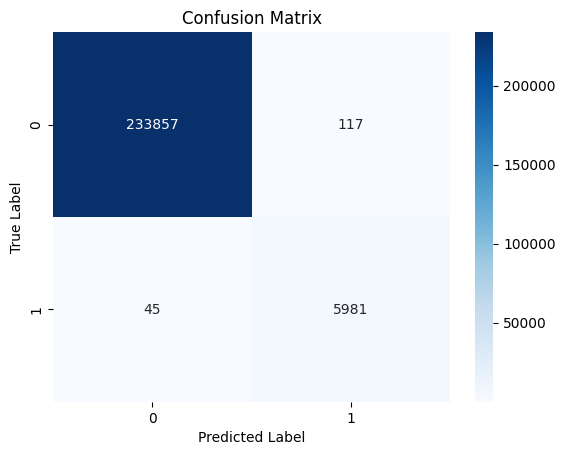

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [40]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  
    ('scaler', StandardScaler()),                                
    ('rf', RandomForestClassifier())                  
])
param_rf = {
    'rf__n_estimators':[100,200,300],
    'rf__max_depth': [5,6,9,11,13,15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}
rf_clasifier=RandomizedSearchCV(pipeline_rf,param_distributions=param_rf,n_iter=5,  
    scoring='accuracy',  
    cv=5,  
    verbose=3,  
    n_jobs=-1)

start_time=timer(None)
rf_clasifier.fit(X_train, y_train)
timer(start_time)

# Get the best parameters and score
best_params = rf_clasifier.best_params_
best_estima = rf_clasifier.best_estimator_
best_score = rf_clasifier.best_score_

print("Best Parameters:", best_params)
print("Best estimator:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time Taken 0.0 hours 57.0 minutes and 36.48 seconds 
Best Parameters: {'rf__max_depth': 13, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 259}
Best estimator: {'rf__max_depth': 13, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 259}
Best Cross-Validation Score: 0.9968354166666666


In [41]:
best_pipeline_rf = rf_clasifier.best_estimator_
y_pred_rf = best_pipeline_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("f1_socre:", f1_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))

print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9971
Precision: 0.900390625
f1_socre: 0.9451190663933133
Recall: 0.9945237305011616
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233974
           1       0.90      0.99      0.95      6026

    accuracy                           1.00    240000
   macro avg       0.95      1.00      0.97    240000
weighted avg       1.00      1.00      1.00    240000

confusion Matrix:
 [[233311    663]
 [    33   5993]]


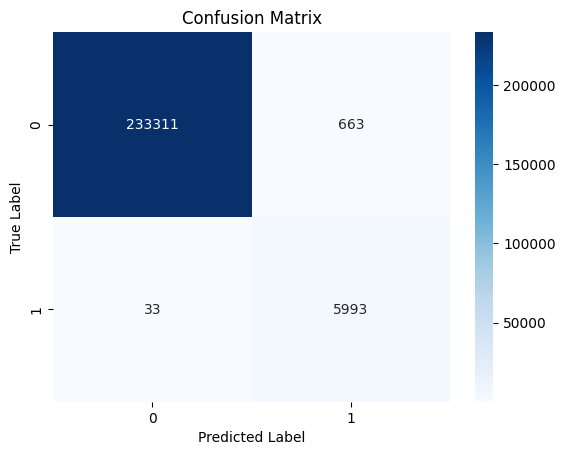

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
pipeline_dt = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  
    ('scaler', StandardScaler()),                                
    ('dt', DecisionTreeClassifier())                  
])
param_dt = {
    'dt__criterion':['gini','entropy'],
    'dt__max_depth': [5,6,9,11,13,15],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_clasifier=RandomizedSearchCV(pipeline_dt,param_distributions=param_dt,n_iter=5,  
    scoring='accuracy',  
    cv=5,  
    verbose=3,  
    n_jobs=-1)

start_time=timer(None)
dt_clasifier.fit(X_train, y_train)
timer(start_time)

# Get the best parameters and score
best_params_dt = dt_clasifier.best_params_
best_estima_dt = dt_clasifier.best_estimator_
best_score_dt = dt_clasifier.best_score_

print("Best Parameters:", best_params_dt)
print("Best estimator:", best_estima_dt)
print("Best Cross-Validation Score:", best_score_dt)

In [ ]:
best_pipeline_dt = rf_clasifier.best_estimator_
y_pred_dt = best_pipeline_dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("f1_socre:", f1_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))

print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))